# This is Forecasting Future Global Temperatures Using the Global Temperatures Dataset

In [85]:
#Import Dependencies
import numpy as np
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy

In [41]:
#Load DataSet run Initial 
global_temps = pd.read_csv('GlobalTemperatures.csv')
global_temps.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


In [84]:
#Create function to convert from Celsius to Farenheit
def convert_temp(celsius):
    return celsius * 1.8 + 32
#Test Function
convert_temp(12.548)

54.5864

In [86]:
#Create Norm Inverse Function for Simulation
def norminv(prob, mu, sigma):
    x = scipy.stats.norm(mu, sigma)
    return x.ppf(prob)

In [52]:
#Apply Lamda to convert Date String Column to DateTime and create a 'year' column to group on
global_temps['dt'] = global_temps['dt'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%Y-%m-%d'))
global_temps['year'] = global_temps['dt'].apply(lambda x: x.year)

In [176]:
global_temps.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,year
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057,2015
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058,2015
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062,2015
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063,2015
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062,2015


In [180]:
#Create new dataset where group on is done by year
temps_year = global_temps.groupby(['year']).mean()
#Filter Years less than 1850 where data is unreliable
temps_year = temps_year[temps_year.index > 1849]

In [181]:
#Create new columns of Farenheit converted Temperatures
temps_year['LandAverageTemp_Far'] = temps_year['LandAverageTemperature'].apply(lambda x: convert_temp(x)) 
temps_year['LandMaxTemp_Far'] = temps_year['LandMaxTemperature'].apply(lambda x: convert_temp(x)) 

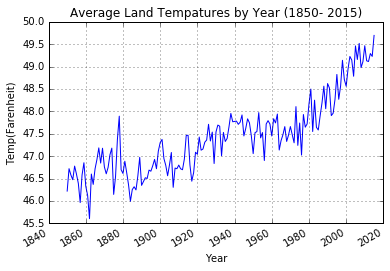

In [224]:
#Plot Average Land Temperatures (1850-2015)
plt.plot(temps_year['LandAverageTemp_Far'])
plt.ylabel('Temp(Farenheit)')
plt.xlabel('Year')
plt.title('Average Land Tempatures by Year (1850- 2015)')
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

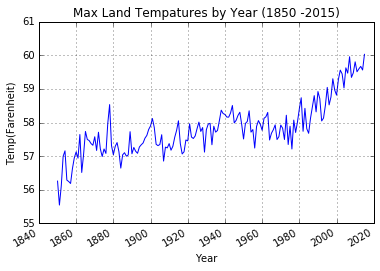

In [225]:
#Plot Max Temperatures
plt.plot(temps_year['LandMaxTemp_Far'])
plt.ylabel('Temp(Farenheit)')
plt.xlabel('Year')
plt.title('Max Land Tempatures by Year (1850 -2015)')
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

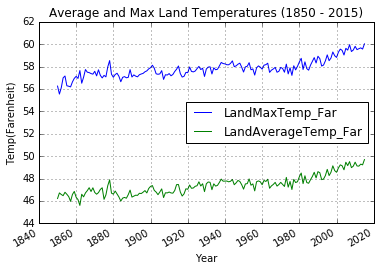

In [226]:
#Plot by Max and Average Temperatures
plt.plot(temps_year['LandMaxTemp_Far'])
plt.plot(temps_year['LandAverageTemp_Far'])
plt.ylabel('Temp(Farenheit)')
plt.xlabel('Year')
plt.title('Average and Max Land Temperatures (1850 - 2015)')
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

# Simulate the Average Temp for the Next 100 Years

In [285]:
num_simulations = 2000
for j in range(num_simulations):
    lst = []
    indices = []
    last = 0
    for current in temps_year['LandAverageTemp_Far']:
        if len(lst) == 0:
            lst.append(np.nan)
            last = current
        else:
            lst.append(current / last)
            last = current
    indices = temps_year.index.values.tolist()

    for i in range(len(indices)):
        indices[i] = int(indices[i])
    change_results = pd.DataFrame(lst, index = indices, columns = ['yr_yr_change'])
    result = pd.concat([temps_year, change_results], axis=1)
    changed_avg = result['yr_yr_change'].mean()
    changed_stdev = np.std(result['yr_yr_change'])
    #Run 100 years of simulation from last year using norminv function and random variable
    simulation_end = []
    num_years = 100
    for item in temps_year['LandAverageTemp_Far']:
        simulation_end.append(item)
    yr_end = simulation_end[-1] 
    for i in range(num_years):
        yr_end = norminv(np.random.random_sample(), changed_avg, changed_stdev) * yr_end
        indices.append(indices[-1] + 1)
        simulation_end.append(yr_end)
    simulation = pd.DataFrame(simulation_end, index = indices, columns = [str(j)])
    if j == 0:
        #Initialize New DataFrame with First Years Results
        simulation_compiled = simulation
    else:
        simulation_compiled = pd.concat([simulation_compiled, simulation], axis=1)
    if j % 1000 == 0:
        print str(j) + ' Number of Simulations Complete'

0 Number of Simulations Complete
1000 Number of Simulations Complete


In [286]:
#Add columns of Statistically Significant Forecasts for each year
simulation_compiled['mean'] = simulation_compiled.mean(axis = 1)
simulation_compiled['max'] = simulation_compiled.max(axis = 1)
simulation_compiled['min'] = simulation_compiled.min(axis = 1)
simulation_compiled['median'] = simulation_compiled.median(axis = 1)
simulation_compiled['75th'] = simulation_compiled.quantile(.75, axis = 1)
simulation_compiled['25th'] = simulation_compiled.quantile(.25, axis = 1)

# Chart the Results of the Simulation

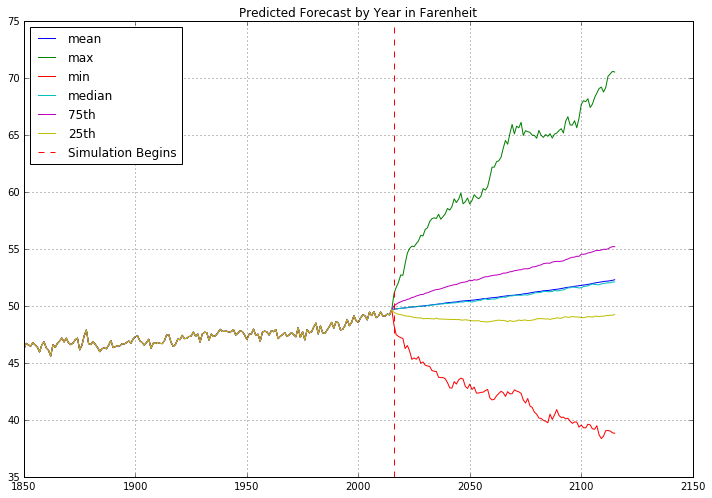

In [287]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(simulation_compiled['mean'])
ax.plot(simulation_compiled['max'])
ax.plot(simulation_compiled['min'])
ax.plot(simulation_compiled['median'])
ax.plot(simulation_compiled['75th'])
ax.plot(simulation_compiled['25th'])
plt.title('Predicted Forecast by Year in Farenheit')
ax.axvline(2016, color = 'r', linestyle='--', label = 'Simulation Begins')
ax.legend(loc = 'best')
fig.tight_layout()
ax.grid()


In [289]:
print simulation_compiled['mean'][2015], simulation_compiled['mean'][2115], simulation_compiled['75th'][2115]

49.6958 52.307590959 55.2190597389


Following current trends in rising temperatures, the graph shows in a moderate rise in current average global temperatures of 2.5 degrees over the next 100 years (from 49.7 degress (2015) to 52.2 degrees (2116)) 
25% of the simulations show a moderate decrease in average global temperatures while 75% of the simulations show an increase of about 5 degrees overall. 

# Time Series Forecast